## Logistic Regression with Regularization

First normal multiple logistic regression is implemented.

Then feature importance is investigated with permutation importance. This gives a good and intuitive measure of feature importance, and the results are congruent with the synthetic data generation.

Lastly regularization is implemented. 

Large alpha values leads to negative values for unimportant coefficients. Low values leads to little difference. 
In the sweet spot between these two extremes the regularization seems to accomplish smaller values overall. 

The conclusion is that permutation importance seems to be best measure of feature importance. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# Set random seed for reproducibility
np.random.seed(0)

# Define the number of samples
n_samples = 1000

# Generate random feature data
feature1 = np.random.normal(0, 1, n_samples)  # Important feature
feature2 = np.random.normal(0, 1, n_samples)  # Important feature
feature3 = np.random.normal(0, 0.2, n_samples)  # Less important feature

# Combine features into a feature matrix
X = np.column_stack((feature1, feature2, feature3))

# Define true logistic regression coefficients
# Feature1 and Feature2 are important, Feature3 is less important
true_coeffs = np.array([1.0, 1.0, 0.2])

# Generate the target variable (binary outcome)
# Use a logistic function with added noise
logits = np.dot(X, true_coeffs)

# Add some random noise
noise = np.random.normal(0, 0.2, n_samples)
logits_with_noise = logits + noise
# Apply the logistic function to get probabilities
probability = 1 / (1 + np.exp(-logits_with_noise))
# labels = np.random.binomial(1, probability, n_samples)

# Generate binary labels based on a threshold (e.g., 0.5)
labels = (probability > 0.5).astype(int)

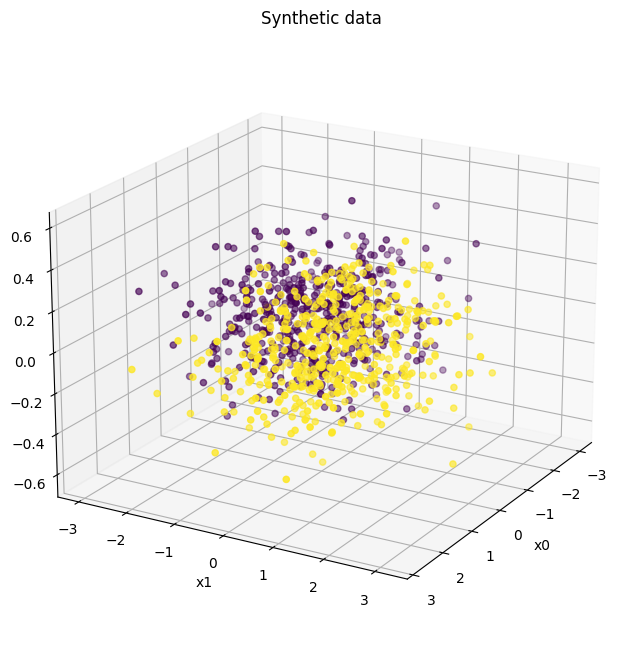

In [19]:
# Create a figure and a 3D axis
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatterplot
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.squeeze(), marker='o')

# Set axis labels
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')

# Set the view angle for better visibility of the Z-axis label
ax.view_init(elev=20, azim=30)

plt.title("Synthetic data")
plt.show()

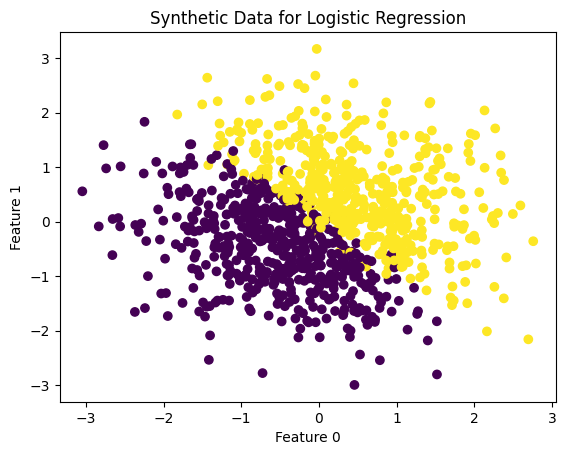

In [23]:
# Scatter plot of the data points
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Feature 0 and 1 (important features)")
plt.show()

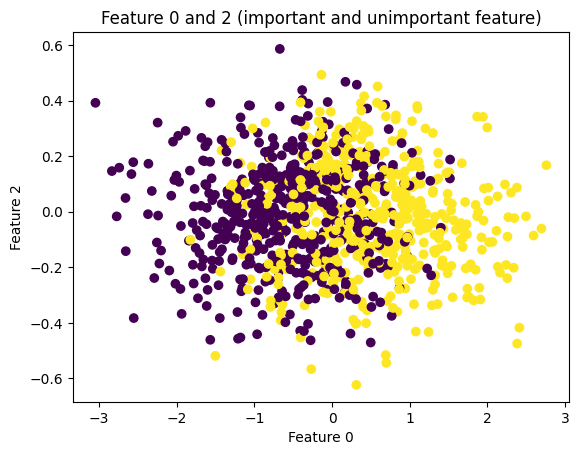

In [24]:
# Scatter plot of the data points
plt.scatter(X[:, 0], X[:, 2], c=labels)
plt.xlabel("Feature 0")
plt.ylabel("Feature 2")
plt.title("Feature 0 and 2 (important and unimportant feature)")
plt.show()

## Optimization

In [225]:
def logistic_function(x):
    return 1 / (1 + np.exp(-x))

In [226]:
def forward(X, coeffs):
    logits = np.matmul(X, coeffs)
    return logistic_function(logits)

In [227]:
def predict(y_prob):
    cutoff = 0.5
    # Use np.where to round values to 1 if they are greater than or equal to the cutoff, and 0 otherwise
    return (y_prob.flatten() >= cutoff).astype(int)

In [228]:
def calculate_accuracy(y_pred, y_true):
    # Compare the two arrays element-wise
    correctly_classified = (y_pred == y_true)
    # Count the number of True values (correct classifications)
    num_correct = np.sum(correctly_classified)
    # Calculate the accuracy as a percentage
    return (num_correct / len(labels)) * 100

In [229]:
def objective(y_prob, y_true):
    y_prob = y_prob.flatten()
    return np.mean(-y_true * np.log(y_prob) - (1 - y_true) * np.log(1 - y_prob))

In [230]:
def gradient(y_prob, y_true, X):
    y_true = y_true[:, np.newaxis]
    diff = y_prob - y_true
    return np.matmul(diff.T, X).T

In [231]:
coeffs = np.random.rand(3, 1)
n_iter = 20
lr = 0.0005
losses = []
accs = []

for i in range(n_iter):
    y_prob = forward(X, coeffs)
    
    grad = gradient(y_prob, labels, X)
    
    coeffs -= lr * grad
    
    loss = objective(y_prob, labels)
    print(f'Loss: {loss}', end=", ")
    losses.append(loss)
    
    y_pred = predict(y_prob)
    accuracy = calculate_accuracy(y_pred, labels)
    print(f'Accuracy {accuracy}')
    accs.append(accuracy)

print()
print(f'Optimal coefficients: \n{coeffs}')

Loss: 0.5142107205194715, Accuracy 78.4
Loss: 0.4799556692373035, Accuracy 82.0
Loss: 0.45161618822707933, Accuracy 84.8
Loss: 0.42791367927729573, Accuracy 86.9
Loss: 0.40786063017406776, Accuracy 88.3
Loss: 0.3907008565245487, Accuracy 89.5
Loss: 0.3758560987151812, Accuracy 91.0
Loss: 0.36288265356665916, Accuracy 91.5
Loss: 0.35143788444707447, Accuracy 92.10000000000001
Loss: 0.34125503464286616, Accuracy 92.60000000000001
Loss: 0.33212452299930795, Accuracy 92.9
Loss: 0.32388011283637297, Accuracy 93.2
Loss: 0.31638867561164746, Accuracy 93.5
Loss: 0.309542584281099, Accuracy 93.60000000000001
Loss: 0.30325402671842505, Accuracy 94.0
Loss: 0.29745072391334915, Accuracy 94.19999999999999
Loss: 0.2920726805807525, Accuracy 94.39999999999999
Loss: 0.28706969908969326, Accuracy 94.6
Loss: 0.28239946167586344, Accuracy 94.8
Loss: 0.2780260388894318, Accuracy 94.69999999999999

Optimal coefficients: 
[[1.5714053 ]
 [1.41684407]
 [0.54104009]]


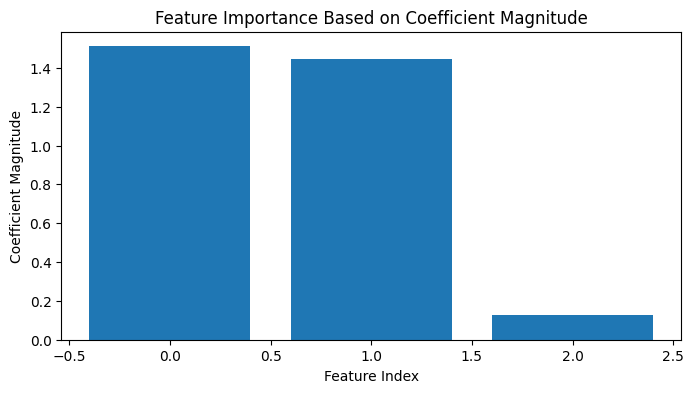

In [194]:
# Assuming you have the optimal coefficients in a NumPy array named 'optimal_coeffs'

coeffs = coeffs.flatten()

# 1. Magnitude of Coefficients
coeff_magnitude = np.abs(coeffs)

# 2. Sign of Coefficients
coeff_sign = np.sign(coeffs)

# 3. Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(coeffs)), coeff_magnitude)
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Magnitude")
plt.title("Feature Importance Based on Coefficient Magnitude")
plt.show()

## Permutation importance

In [212]:
# Evaluate the model's accuracy on the test set
y_prob = forward(X, coeffs)
y_pred = predict(y_prob)
original_accuracy = calculate_accuracy(y_pred, labels)

# Initialize a dictionary to store permutation importances
perm_importances = {}

# Iterate through each feature and calculate permutation importance
for feature_idx in range(X.shape[1]):
    # Make a copy of the test data to shuffle the feature
    X_test_shuffled = X.copy()
    np.random.shuffle(X_test_shuffled[:, feature_idx])  # Shuffle the feature values
    
    
    y_prob = forward(X_test_shuffled, coeffs)
    y_pred = predict(y_prob)
    # Calculate accuracy after shuffling the feature
    shuffled_accuracy = calculate_accuracy(y_pred, labels)

    # Calculate permutation importance (drop in accuracy)
    perm_importance = original_accuracy - shuffled_accuracy
    
    # Store the permutation importance in the dictionary
    perm_importances[feature_idx] = perm_importance


# Calculate the maximum importance value
max_importance = max(perm_importances.values())

# Scale the permutation importances to the range [0, 1]
scaled_perm_importances = {feature_idx: importance / max_importance for feature_idx, importance in perm_importances.items()}

# Sort the scaled feature importances
sorted_scaled_perm_importances = sorted(scaled_perm_importances.items(), key=lambda x: x[1], reverse=True)

# Print the sorted, scaled feature importances
for feature_idx, importance in sorted_scaled_perm_importances:
    print(f"Feature {feature_idx}: Scaled Permutation Importance = {abs(importance):.4f}")

Feature 0: Scaled Permutation Importance = 1.0000
Feature 1: Scaled Permutation Importance = 0.9441
Feature 2: Scaled Permutation Importance = 0.0105


## Regularization

In [523]:
alpha = 5

In [524]:
def objective_with_regularization(y_prob, y_true, coeffs):
    J = objective(y_prob, y_true)
    reg_term = np.mean(alpha * np.power(coeffs, 2)) / 2    
    return J + reg_term

In [525]:
def gradient_with_regularization(y_prob, y_true, X, coeffs):
    G = gradient(y_prob, y_true, X)
        
    reg_term = np.mean(alpha * coeffs)
    
    return G + reg_term

In [526]:
np.random.seed(4)

coeffs = np.random.rand(3, 1)
n_iter = 100
lr = 0.0005
losses = []
accs = []

for i in range(n_iter):
    y_prob = forward(X, coeffs)
    
    grad = gradient_with_regularization(y_prob, labels, X, coeffs)
    
    coeffs -= lr * grad
    
    loss = objective_with_regularization(y_prob, labels, coeffs)
    print(f'Loss: {loss}', end=", ")
    losses.append(loss)
    
    y_pred = predict(y_prob)
    accuracy = calculate_accuracy(y_pred, labels)
    print(f'Accuracy {accuracy}')
    accs.append(accuracy)

print()
print(f'Optimal coefficients: \n{coeffs}')

Loss: 2.3738390809505447, Accuracy 88.5
Loss: 2.5016120145723724, Accuracy 89.4
Loss: 2.6336886209103265, Accuracy 90.7
Loss: 2.7686770117824864, Accuracy 91.4
Loss: 2.905539859538129, Accuracy 91.7
Loss: 3.0434986917337237, Accuracy 92.2
Loss: 3.181965689983831, Accuracy 92.60000000000001
Loss: 3.3204947275466754, Accuracy 92.9
Loss: 3.458745917064146, Accuracy 93.5
Loss: 3.596459707200902, Accuracy 93.89999999999999
Loss: 3.733437781974196, Accuracy 94.0
Loss: 3.8695288484936614, Accuracy 94.5
Loss: 4.004617969147021, Accuracy 94.39999999999999
Loss: 4.138618486984831, Accuracy 94.6
Loss: 4.271465865211909, Accuracy 94.69999999999999
Loss: 4.403112951720079, Accuracy 94.8
Loss: 4.533526313363671, Accuracy 94.69999999999999
Loss: 4.662683379639166, Accuracy 94.69999999999999
Loss: 4.790570203416425, Accuracy 94.69999999999999
Loss: 4.917179695454871, Accuracy 94.8
Loss: 5.0425102251713145, Accuracy 94.8
Loss: 5.16656450634878, Accuracy 94.8
Loss: 5.289348705868747, Accuracy 94.8
Loss:

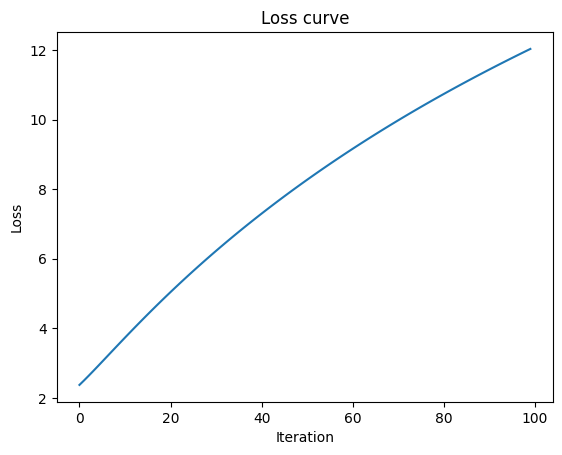

In [527]:
# plot loss curve
iterations = np.arange(n_iter)
plt.plot(iterations, losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.show()

In [214]:
np.power(coeffs, 2)

array([2.28158883, 2.08357021, 0.01647138])